<a href="https://colab.research.google.com/github/SergiiRv/Neuromatch-2023/blob/main/Sergii_Copy_of_load_steinmetz_decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import pandas as pd

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
#from colorama import Fore, Back, Style
import sklearn as sk

import gc
from scipy import signal

from google.colab import files

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#lloking into dimentions of different parameters

"""
col =list(alldat[0].keys())
session = []
dimlistL = []
for i, ditem in enumerate(alldat):
  session.append([i])
  dimlist = []
  for key in col:
    #print(1, key)
    try:
      ditem[key].shape
      dimlist.append([ditem[key].shape])
    except:
      dimlist.append([type(ditem[key])])
  dimlistL.append(dimlist)


dimentionsDF = pd.DataFrame(dimlistL)#, index=session, columns = col)
dimentionsDF.columns = col
dimentionsDF.index.name = 'Session'
dimentionsDF.head(10)
"""

"\ncol =list(alldat[0].keys())\nsession = []\ndimlistL = []\nfor i, ditem in enumerate(alldat):\n  session.append([i])\n  dimlist = []\n  for key in col:\n    #print(1, key)\n    try:\n      ditem[key].shape\n      dimlist.append([ditem[key].shape])\n    except:\n      dimlist.append([type(ditem[key])])\n  dimlistL.append(dimlist)\n\n\ndimentionsDF = pd.DataFrame(dimlistL)#, index=session, columns = col)\ndimentionsDF.columns = col\ndimentionsDF.index.name = 'Session'\ndimentionsDF.head(10)\n"

In [ ]:
#del dimentionsDF
#gc.collect()

In [ ]:
regions = ["vis ctx", "thal", "hipp", "non-visual cortex", "midbrain", "basal ganglia", "cortical subplate"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_region = {}
counter = 1
for i, group in enumerate(brain_groups):
    for area in group:
        area_to_region[area] = regions[i]

# helper function to make column of association between brain region corresponding to brain area
def brain_part(brainreion, BrainDictionary):
  partL = []
  for i, item in enumerate(brainreion):
    if item in list(BrainDictionary.keys()):
      part = BrainDictionary[item]
    else:
      part = "other"
    partL.append(part)
  return np.array(partL)

In [ ]:
"""

# lets do what is in ''---------------2--------'' but for one session:
try:
    del DFL
except NameError:
    pass

BA = np.array([])
nn = np.array([])
# in this cycle we are going through all sessions and collect data on
#"Session", "Trial", 'response', 'feedback_type', 'licks', 'gocue', 'response_time', 'brain_area', 'Brain_Part', 'NeuronNumber'
# into a dataframe so every row will tell us the abouve parameters on every sigle neuron in the whole dataset
# in paralel we aggregate the all spikes data so the every row of this array will corresponf to the newuron described in the corresponding row in the dataframe
for i, ditem in enumerate(alldat[11:12]):
  BA = ditem['brain_area']
  BP = brain_part(BA, area_to_region)
  nn = np.array(range(len(ditem['brain_area'])))
  neuron_BA_BP = np.array([BA, BP, nn]).T
  df = pd.DataFrame(np.array([
                    np.ones(len(ditem['response']))*(i),          # Session
                    np.array(range(len(ditem['response']))),      # Trial
                    ditem['response'].reshape(-1),                # Responce
                    ditem['feedback_type'].reshape(-1),           # Feedback type
                    np.sum(ditem['licks'], axis = 2).reshape(-1), # Licks
                    np.array([ditem['gocue']*1000//100], dtype=np.int_).ravel(),  #GoCue time
                    np.array([ditem['response_time']*1000//100], dtype=np.int_).ravel()
                    ]).T)

  df = df.loc[np.repeat(df.index.values, neuron_BA_BP.shape[0])]
  DF_neuron_BA_BP = pd.DataFrame(np.tile(neuron_BA_BP, (len(df) // neuron_BA_BP.shape[0],1))[:len(df)])
  df = pd.concat([df.reset_index(drop=True), DF_neuron_BA_BP], axis=1, ignore_index=True, sort=False)
  df.columns = ["Session", "Trial", 'response', 'feedback_type', 'licks', 'gocue', 'response_time', 'brain_area', 'Brain_Part', 'NeuronNumber']

  Spikes1 = np.transpose(ditem['spks'],(1, 0, 2)).reshape((-1, ditem['spks'].shape[2]))
  a = Spikes1.shape[0]
  Spikes2_ = np.mean(Spikes1.reshape(a, -1, 10), axis=2)

  #print("a=", a, "Spikes2=", Spikes2.shape)
  Spikes2 = np.zeros((Spikes2_.shape[0], 5+12+19))
  for k in range(Spikes2_.shape[0]):
    gc_index = df['gocue'][k].astype(int)
    gc_ = np.pad(Spikes2_[k, 5:gc_index+5], (0, 12 - len(Spikes2_[k, 5:gc_index+5])), 'edge')
    #rt_index = df['response_time'][k].astype(int)
    rt = np.pad(Spikes2_[k, gc_index+5:], (0, 19 - len(Spikes2_[k, gc_index+5:])), 'edge')
    Spikes2[k] = np.concatenate((Spikes2_[k][:5], gc_, rt))

  #print("i=", i)
  if i==0:
    DFL = df
    Spikes = Spikes2_
  else:
    DFL = pd.concat([DFL, df], axis=0).reset_index(drop=True)
    Spikes = np.concatenate((Spikes, Spikes2), axis=0)

  indices = np.where(np.sum(Spikes, axis = 1) == 0)
  DFL = DFL.drop(indices[0])
  Spikes = np.delete(Spikes, indices[0], axis=0)

DFL['StationaryIndex'] = np.array(range(len(DFL)))
DFL_grouped_session = DFL.groupby(["Trial"])['StationaryIndex'].unique()

# here we free up the memory off excessive variables
neuron_BA_BP = None
BA = None
BP = None
nn = None
Spikes1 = None
Spikes2 = None
del DF_neuron_BA_BP
#alldat = None
gc.collect()

Spikes_grouped_mean = np.zeros((len(DFL_grouped_session), 25))
Spikes_grouped_std = np.zeros((len(DFL_grouped_session), 25))
for i in range(len(DFL_grouped_session)):
  Spikes_grouped_mean[i,:] = np.mean(Spikes[DFL_grouped_session[i],:], axis = 0)
  Spikes_grouped_std[i,:] = np.std(Spikes[DFL_grouped_session[i],:], axis = 0)

"""

'\n\n# lets do what is in \'\'---------------2--------\'\' but for one session:\ntry:\n    del DFL\nexcept NameError:\n    pass\n\nBA = np.array([])\nnn = np.array([])\n# in this cycle we are going through all sessions and collect data on\n#"Session", "Trial", \'response\', \'feedback_type\', \'licks\', \'gocue\', \'response_time\', \'brain_area\', \'Brain_Part\', \'NeuronNumber\'\n# into a dataframe so every row will tell us the abouve parameters on every sigle neuron in the whole dataset\n# in paralel we aggregate the all spikes data so the every row of this array will corresponf to the newuron described in the corresponding row in the dataframe\nfor i, ditem in enumerate(alldat[11:12]):\n  BA = ditem[\'brain_area\']\n  BP = brain_part(BA, area_to_region)\n  nn = np.array(range(len(ditem[\'brain_area\'])))\n  neuron_BA_BP = np.array([BA, BP, nn]).T\n  df = pd.DataFrame(np.array([\n                    np.ones(len(ditem[\'response\']))*(i),          # Session\n                    np.ar

In [ ]:
"""

#Spikes_grouped_mean.shape
CorrM_mean = np.corrcoef(Spikes_grouped_mean)
CorrM_std = np.corrcoef(Spikes_grouped_std)

CovM_mean = np.cov(Spikes_grouped_mean)
CovM_std = np.cov(Spikes_grouped_std)


CorrLmean =[]
CorrLstd = []
for i in range(Spikes_grouped_mean.shape[0]-1):
  corr_mean = np.max(np.abs(signal.correlate(Spikes_grouped_mean[i,:], Spikes_grouped_mean[i+1,:])))
  CorrLmean.append(corr_mean)
  corr_std = np.max(np.abs(signal.correlate(Spikes_grouped_std[i,:], Spikes_grouped_std[i+1,:])))
  CorrLstd.append(corr_std)
CorrLmean = np.array(CorrLmean)
CorrLstd = np.array(CorrLstd)

"""

'\n\n#Spikes_grouped_mean.shape\nCorrM_mean = np.corrcoef(Spikes_grouped_mean)\nCorrM_std = np.corrcoef(Spikes_grouped_std)\n\nCovM_mean = np.cov(Spikes_grouped_mean)\nCovM_std = np.cov(Spikes_grouped_std)\n\n\nCorrLmean =[]\nCorrLstd = []\nfor i in range(Spikes_grouped_mean.shape[0]-1):\n  corr_mean = np.max(np.abs(signal.correlate(Spikes_grouped_mean[i,:], Spikes_grouped_mean[i+1,:])))\n  CorrLmean.append(corr_mean)\n  corr_std = np.max(np.abs(signal.correlate(Spikes_grouped_std[i,:], Spikes_grouped_std[i+1,:])))\n  CorrLstd.append(corr_std)\nCorrLmean = np.array(CorrLmean)\nCorrLstd = np.array(CorrLstd)\n\n'

In [ ]:
"""

from sklearn.covariance import GraphicalLassoCV

model = GraphicalLassoCV()
model.fit(Spikes_grouped_mean.T)
cov_ = model.covariance_

plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(cov_, dtype=bool))
sns.heatmap(cov_, cmap='coolwarm', mask=mask)

"""

"\n\nfrom sklearn.covariance import GraphicalLassoCV\n\nmodel = GraphicalLassoCV()\nmodel.fit(Spikes_grouped_mean.T)\ncov_ = model.covariance_\n\nplt.figure(figsize=(10, 10))\nmask = np.triu(np.ones_like(cov_, dtype=bool))\nsns.heatmap(cov_, cmap='coolwarm', mask=mask)\n\n"

In [ ]:
"""
plt.figure(figsize=(6, 4))
plt.plot(np.array(range(len(CorrLmean))), CorrLmean, '-r', label='Correlation of neighbouring trials - Mean')
plt.title('Correlation of neighbouring trials - Mean')
plt.figure(figsize=(6, 4))
plt.plot(np.array(range(len(CorrLmean))), CorrLstd,'-b', label='Correlation of neighbouring trials - std')
plt.title('Correlation of neighbouring trials - std')
"""

"\nplt.figure(figsize=(6, 4))\nplt.plot(np.array(range(len(CorrLmean))), CorrLmean, '-r', label='Correlation of neighbouring trials - Mean')\nplt.title('Correlation of neighbouring trials - Mean')\nplt.figure(figsize=(6, 4))\nplt.plot(np.array(range(len(CorrLmean))), CorrLstd,'-b', label='Correlation of neighbouring trials - std')\nplt.title('Correlation of neighbouring trials - std')\n"

In [ ]:
"""

#CorrM.shape
plt.figure(figsize=(6, 4))

# Plot the mean values as a line plot
plt.plot(np.tile(np.array(range(25)), (Spikes_grouped_mean.shape[0], 1)), Spikes_grouped_mean, marker='o', label='Mean')

# Plot the standard deviation as error bars
#plt.errorbar(np.tile(np.array(range(25)), (Spikes_grouped_mean.shape[0], 1)), Spikes_grouped_mean, yerr=Spikes_grouped_std, fmt='none', ecolor='red', capsize=5, label='Std Dev')

plt.figure(figsize=(6, 4))
plt.plot(np.tile(np.array(range(25)), (Spikes_grouped_mean.shape[0], 1)).T, Spikes_grouped_mean.T, label='Mean')


plt.figure(figsize=(6, 4))
plt.plot(np.array(range(25)), np.mean(Spikes_grouped_mean, axis = 0), label='Mean')

"""

"\n\n#CorrM.shape\nplt.figure(figsize=(6, 4))\n\n# Plot the mean values as a line plot\nplt.plot(np.tile(np.array(range(25)), (Spikes_grouped_mean.shape[0], 1)), Spikes_grouped_mean, marker='o', label='Mean')\n\n# Plot the standard deviation as error bars\n#plt.errorbar(np.tile(np.array(range(25)), (Spikes_grouped_mean.shape[0], 1)), Spikes_grouped_mean, yerr=Spikes_grouped_std, fmt='none', ecolor='red', capsize=5, label='Std Dev')\n\nplt.figure(figsize=(6, 4))\nplt.plot(np.tile(np.array(range(25)), (Spikes_grouped_mean.shape[0], 1)).T, Spikes_grouped_mean.T, label='Mean')\n\n\nplt.figure(figsize=(6, 4))\nplt.plot(np.array(range(25)), np.mean(Spikes_grouped_mean, axis = 0), label='Mean')\n\n"

In [ ]:
"""

plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(CorrM_mean, dtype=bool))
sns.heatmap(CorrM_mean, cmap='coolwarm', mask=mask)

"""

"\n\nplt.figure(figsize=(10, 10))\nmask = np.triu(np.ones_like(CorrM_mean, dtype=bool))\nsns.heatmap(CorrM_mean, cmap='coolwarm', mask=mask)\n\n"

In [ ]:
"""
plt.figure(figsize=(10, 10))
#mask = np.triu(np.ones_like(CorrM_mean, dtype=bool))
sns.heatmap(CovM_mean, cmap='coolwarm', mask=mask)

"""

"\nplt.figure(figsize=(10, 10))\n#mask = np.triu(np.ones_like(CorrM_mean, dtype=bool))\nsns.heatmap(CovM_mean, cmap='coolwarm', mask=mask)\n\n"

In [ ]:

#---------------2--------all data aggregate_ FOR ACTIVE TRIALS
try:
    del DFL
except NameError:
    pass

BA = np.array([])
nn = np.array([])
# in this cycle we are going through all sessions and collect data on
#"Session", "Trial", 'response', 'feedback_type', 'licks', 'gocue', 'response_time', 'brain_area', 'Brain_Part', 'NeuronNumber'
# into a dataframe so every row will tell us the abouve parameters on every sigle neuron in the whole dataset
# in paralel we aggregate the all spikes data so the every row of this array will corresponf to the newuron described in the corresponding row in the dataframe
for i, ditem in enumerate(alldat[:]):
  BA = ditem['brain_area']
  BP = brain_part(BA, area_to_region)
  nn = np.array(range(len(ditem['brain_area'])))
  neuron_BA_BP = np.array([BA, BP, nn]).T
  df = pd.DataFrame(np.array([
                    np.ones(len(ditem['response']))*(i),          # Session
                    np.array(range(len(ditem['response']))),      # Trial
                    ditem['response'].reshape(-1),                # Responce
                    ditem['feedback_type'].reshape(-1),           # Feedback type
                    np.sum(ditem['licks'], axis = 2).reshape(-1), # Licks
                    np.array([ditem['gocue']*1000//100], dtype=np.int_).ravel(),  #GoCue time
                    np.array([ditem['response_time']*1000//100], dtype=np.int_).ravel()
                    ]).T)

  df = df.loc[np.repeat(df.index.values, neuron_BA_BP.shape[0])]
  DF_neuron_BA_BP = pd.DataFrame(np.tile(neuron_BA_BP, (len(df) // neuron_BA_BP.shape[0],1))[:len(df)])
  df = pd.concat([df.reset_index(drop=True), DF_neuron_BA_BP], axis=1, ignore_index=True, sort=False)
  df.columns = ["Session", "Trial", 'response', 'feedback_type', 'licks', 'gocue', 'response_time', 'brain_area', 'Brain_Part', 'NeuronNumber']

  Spikes1 = np.transpose(ditem['spks'],(1, 0, 2)).reshape((-1, ditem['spks'].shape[2]))
  a = Spikes1.shape[0]
  Spikes2_ = np.mean(Spikes1.reshape(a, -1, 10), axis=2)
  #print("a=", a, "Spikes2=", Spikes2.shape)
  Spikes2 = np.zeros((Spikes2_.shape[0], 5+12+19))
  for k in range(Spikes2_.shape[0]):
    gc_index = df['gocue'][k].astype(int)
    gc_ = np.pad(Spikes2_[k, 5:gc_index+5], (0, 12 - len(Spikes2_[k, 5:gc_index+5])), 'edge')
    #rt_index = df['response_time'][k].astype(int)
    rt = np.pad(Spikes2_[k, gc_index+5:], (0, 19 - len(Spikes2_[k, gc_index+5:])), 'edge')
    Spikes2[k] = np.concatenate((Spikes2_[k][:5], gc_, rt))

  if i==0:
    DFL = df
    Spikes = Spikes2
  else:
    DFL = pd.concat([DFL, df], axis=0).reset_index(drop=True)
    Spikes = np.concatenate((Spikes, Spikes2), axis=0)

  indices = np.where(np.sum(Spikes, axis = 1) == 0)
  DFL = DFL.drop(indices[0])
  Spikes = np.delete(Spikes, indices[0], axis=0)

In [ ]:
import gc

neuron_BA_BP = None
BA = None
BP = None
nn = None
Spikes1 = None
Spikes2 = None
del DF_neuron_BA_BP
#alldat = None
gc.collect() # here we free up the memory off excessive variables



9

In [ ]:
#DFL['NeuronNumber'] = np.array(map(int, DFL['NeuronNumber']))
DFL['StationaryIndex'] = np.array(range(len(DFL)))

In [ ]:
#DFL.head(10)
Spikes.shape, DFL.shape

((5780573, 36), (5780573, 11))

In [ ]:
# here we are grouping all neurons by factors so we can have indices for Spikes to average over and then calc the Correlation
"""
DFL_grouped = DFL.groupby(['Brain_Part', 'feedback_type', "Session", "Trial"])['StationaryIndex'].unique()
DFL_grouped_RespT = DFL.groupby(['Brain_Part', 'feedback_type', "Session", "Trial"])["response_time"].first()
DFL_grouped_GoCueT = DFL.groupby(['Brain_Part', 'feedback_type', "Session", "Trial"])['gocue'].first()
#DFL_groups_list = list(DFL_grouped.groups.keys())
"""
DFL_grouped = DFL.groupby(['Brain_Part', 'feedback_type'])['StationaryIndex'].unique()

In [ ]:
Spikes_grouped_mean = np.zeros((len(DFL_grouped), 5+12+19))
Spikes_grouped_std = np.zeros((len(DFL_grouped), 5+12+19))
for i in range(len(DFL_grouped)):
  Spikes_grouped_mean[i,:] = np.mean(Spikes[DFL_grouped[i],:], axis = 0)
  Spikes_grouped_std[i,:] = np.std(Spikes[DFL_grouped[i],:], axis = 0)

Spikes_grouped_mean.shape


(16, 36)

In [ ]:
Spikes_grouped_df = pd.DataFrame(Spikes_grouped_mean)
timbin = Spikes_grouped_df.columns.tolist()


In [ ]:
DFL_grouped_ = DFL_grouped.reset_index().drop(['StationaryIndex'],axis=1)
DFL_grouped_combined = pd.concat([DFL_grouped_, Spikes_grouped_df], axis=1).reset_index().drop(['index'],axis=1)

In [ ]:
melted_df = DFL_grouped_combined.melt(id_vars = ['Brain_Part', 'feedback_type'],
                                      value_vars = timbin,
                                      var_name = 'Timebin',
                                      value_name='AvrgdNeuron')

In [ ]:
#DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'], DFL_grouped_

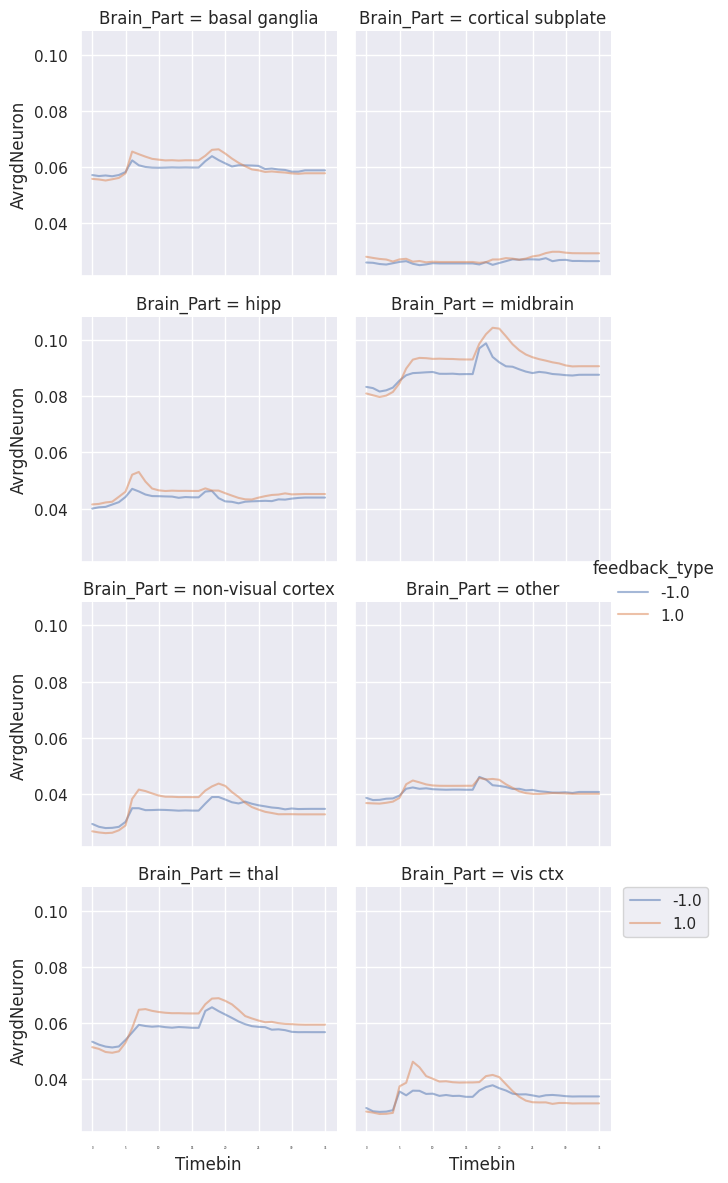

In [ ]:
figsize=(20, 10)
g = sns.FacetGrid(melted_df, col="Brain_Part", col_wrap=2, hue="feedback_type")
g.map(sns.lineplot, 'Timebin', 'AvrgdNeuron', alpha=.5)
g.add_legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.yticks(fontsize=5)
#plt.xticks(np.arange(len(melted_df['Timebin'].unique())), fontsize=9)

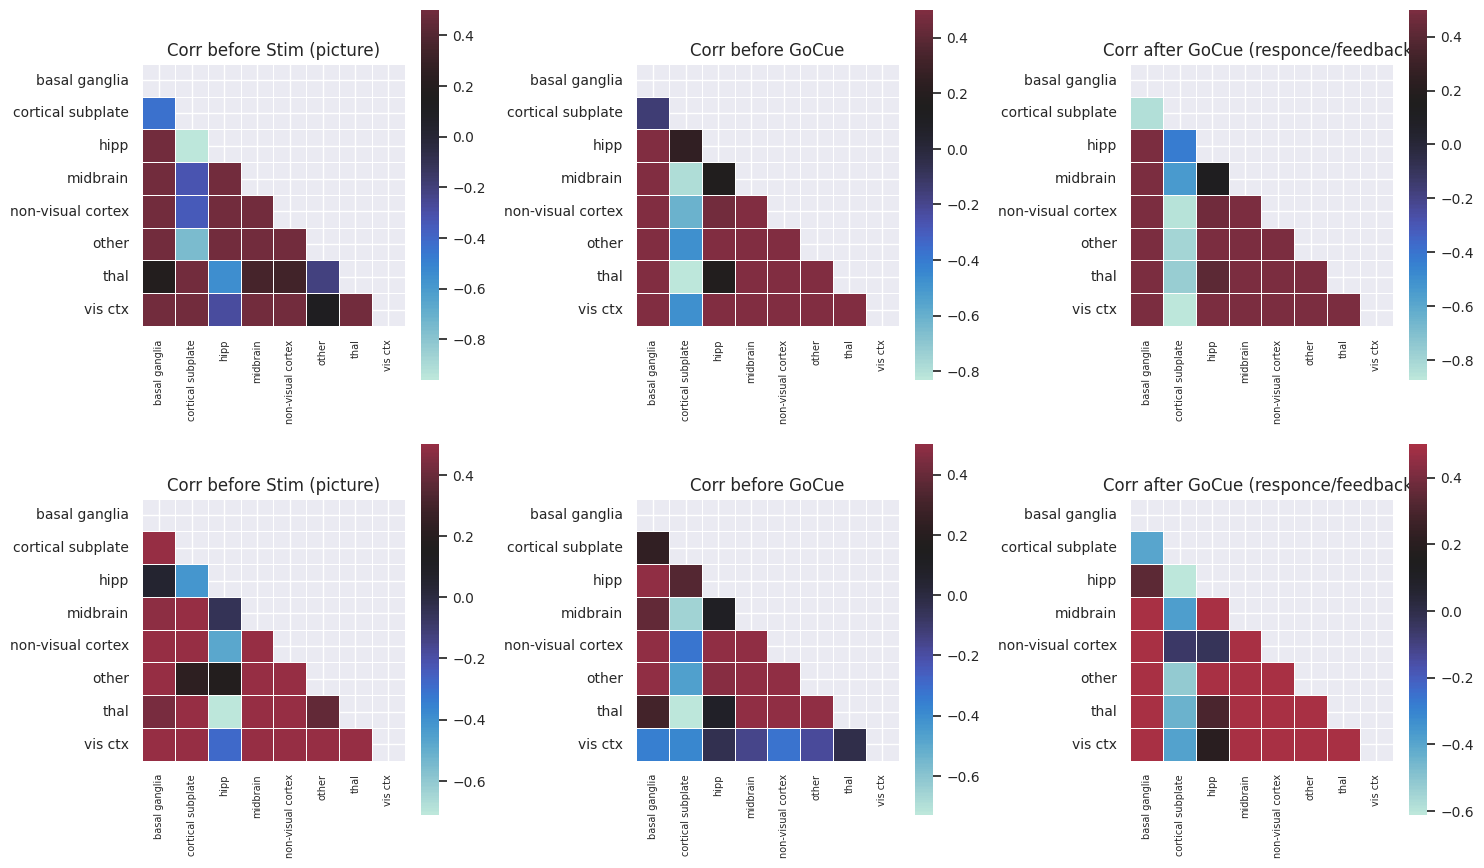

In [ ]:
CorrM_stim_pos = np.corrcoef(Spikes_grouped_mean[DFL_grouped_[DFL_grouped_['feedback_type']==1].index, :5])
CorrM_gocue_pos = np.corrcoef(Spikes_grouped_mean[DFL_grouped_[DFL_grouped_['feedback_type']==1].index, 5:12])
CorrM_resp_pos = np.corrcoef(Spikes_grouped_mean[DFL_grouped_[DFL_grouped_['feedback_type']==1].index, 12:])

CorrM_stim_neg = np.corrcoef(Spikes_grouped_mean[DFL_grouped_[DFL_grouped_['feedback_type']==-1].index, :5])
CorrM_gocue_neg = np.corrcoef(Spikes_grouped_mean[DFL_grouped_[DFL_grouped_['feedback_type']==-1].index, 5:12])
CorrM_resp_neg = np.corrcoef(Spikes_grouped_mean[DFL_grouped_[DFL_grouped_['feedback_type']==-1].index, 12:])

sh=.7
lz = 10
lzx = 7

mask = np.triu(np.ones_like(CorrM_stim_pos, dtype=bool))

plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 3, 1)
sns.heatmap(CorrM_stim_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before Stim (picture)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 3, 2)
sns.heatmap(CorrM_gocue_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before GoCue')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 3, 3)
sns.heatmap(CorrM_resp_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr after GoCue (responce/feedback)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 3, 4)
sns.heatmap(CorrM_stim_neg, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before Stim (picture)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 3, 5)
sns.heatmap(CorrM_gocue_neg, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before GoCue')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 3, 6)
sns.heatmap(CorrM_resp_neg, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr after GoCue (responce/feedback)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

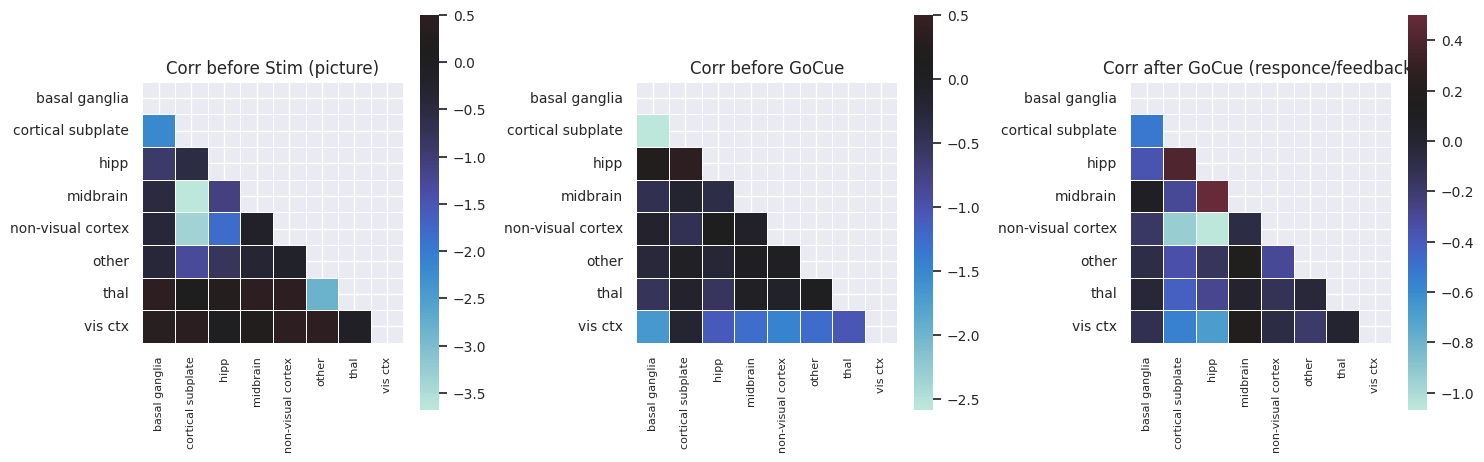

In [ ]:
plt.figure(figsize=(15, 6))

ax = plt.subplot(1, 3, 1)
sns.heatmap(-(CorrM_stim_pos-CorrM_stim_neg)/CorrM_stim_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before Stim (picture)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(1, 3, 2)
sns.heatmap(-(CorrM_gocue_pos-CorrM_gocue_neg)/CorrM_gocue_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before GoCue')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(1, 3, 3)
sns.heatmap(-(CorrM_resp_pos  - CorrM_resp_neg)/CorrM_resp_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr after GoCue (responce/feedback)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})
#-------------------------------------------------------------------------------

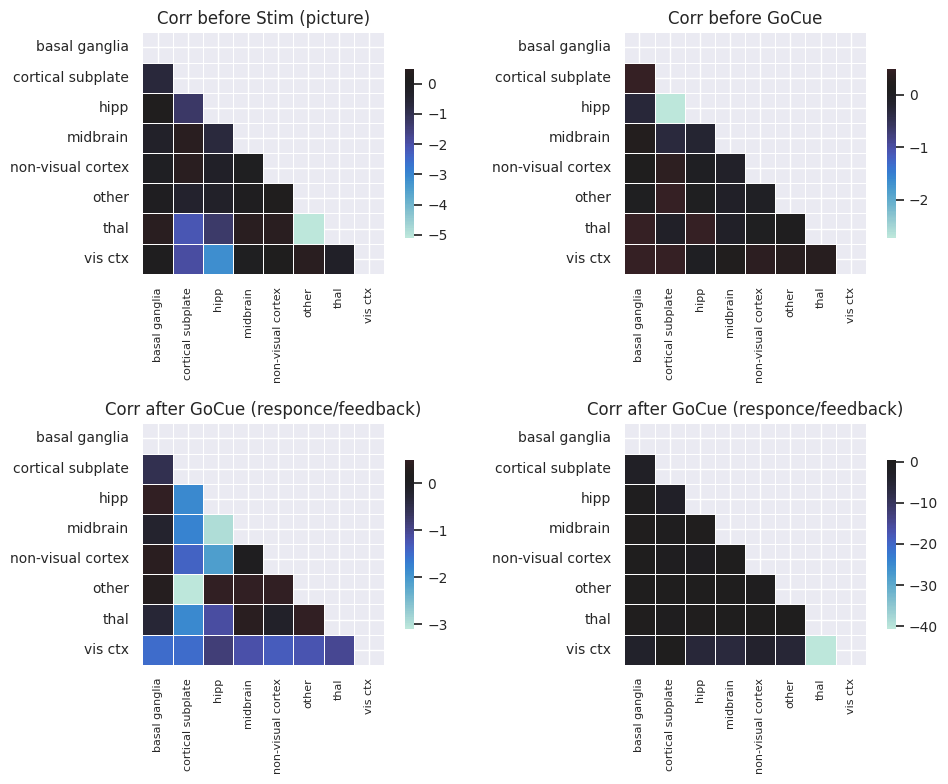

In [ ]:
plt.figure(figsize=(10, 8))

ax = plt.subplot(2, 2, 1)
sns.heatmap((CorrM_gocue_pos - CorrM_stim_pos)/CorrM_stim_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before Stim (picture)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 2, 2)
sns.heatmap((CorrM_resp_pos - CorrM_gocue_pos)/CorrM_gocue_pos, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr before GoCue')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 2, 3)
sns.heatmap((CorrM_gocue_neg - CorrM_stim_neg)/CorrM_stim_neg, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr after GoCue (responce/feedback)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

ax = plt.subplot(2, 2, 4)
sns.heatmap((CorrM_resp_neg - CorrM_gocue_neg)/CorrM_gocue_neg, vmax=.5, center=0.15, yticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            xticklabels=DFL_grouped_[DFL_grouped_['feedback_type']==1]['Brain_Part'],
            mask = mask, square=True, linewidths=.5, cbar_kws={"shrink": sh})
ax.set(title='Corr after GoCue (responce/feedback)')
sns.set(rc={'xtick.labelsize': lzx, 'ytick.labelsize': lz})

In [ ]:
"""
np.savetxt('Spikes1.csv', Spikes[0:1000000,:], delimiter=',')
files.download('Spikes1.csv')
np.savetxt('Spikes2.csv', Spikes[1000000:2000000,:], delimiter=',')
files.download('Spikes2.csv')
np.savetxt('Spikes3.csv', Spikes[2000000:3000000,:], delimiter=',')
files.download('Spikes3.csv')
np.savetxt('Spikes4.csv', Spikes[3000000:4000000,:], delimiter=',')
files.download('Spikes4.csv')
np.savetxt('Spikes5.csv', Spikes[4000000:5000000,:], delimiter=',')
files.download('Spikes5.csv')
np.savetxt('Spikes6.csv', Spikes[5000000:,:], delimiter=',')
files.download('Spikes6.csv')
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""
DFL_grouped.to_csv('DFL_grouped.csv')
DFL_grouped_RespT.to_csv('DFL_grouped_RespT.csv')
files.download('DFL_grouped.csv')
files.download('DFL_grouped_RespT.csv')
DFL_grouped_GoCueT.to_csv('DFL_grouped_GoCueT.csv')
files.download('DFL_grouped_GoCueT.csv')
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# here we just cheking if all good
print(len(DFL_grouped), len(DFL_grouped_RespT))
#DFL_grouped.index[0][0]
DFL_grouped[0].shape
#DFL_grouped_RespT[:100]

#indx = np.array(int(DFL_grouped[0].ravel()))
#indx

48897 48897


(139,)

In [ ]:
# here we are iterating through all groups formed from dataframe, accordingly averaging over all neurons in the group,
#and find correlation coeficient between all groups
#DFL['Brain_Part'].unique()
BP1 = []
BP2 = []
FB1 = []
FB2 = []
S1 = []
S2 = []
T1 = []
T2 = []
sig1l =[]
sig2l = []
corrlist=[]

for i in range(len(DFL_grouped)):
  for ii in range(len(DFL_grouped)):
    sig1 = np.mean(Spikes[DFL_grouped[i],:])
    sig2 = np.mean(Spikes[DFL_grouped[ii],:])
    corr_power = np.max(np.abs(signal.correlate(sig1, sig2)))

    sig1l.append(np.sum(sig1))
    sig2l.append(np.sum(sig2))
    corrlist.append(corr_power)
    BP1.append(DFL_grouped.index[i][0])
    BP2.append(DFL_grouped.index[ii][0])
    FB1.append(DFL_grouped.index[i][1])
    FB2.append(DFL_grouped.index[ii][1])
    #S1.append(DFL_grouped.index[i][2])
    #S2.append(DFL_grouped.index[ii][2])
    #T1.append(DFL_grouped.index[i][3])
    #T2.append(DFL_grouped.index[ii][3])

Spikes = None
gc.collect()

corrDF = pd.DataFrame({
    "BrainPart_1": BP1,
    "BrainPart_2": BP2,
    "feedback_type_1": FB1,
    "feedback_type_2": FB2,
    #'Session_1': S1,
    #'Session_2': S1,
    #"Trial_1": T1,
    #"Trial_2": T2,
    "Corrrelation_1-2": corrlist,
    "sig1lcum_1": sig1l,
    "sig1lcum_2": sig2l
    })


# and here we got trouble of running out of RAM

In [ ]:
corrDF.to_csv('my_corrDF.csv', index=False)

In [ ]:
#---------------3--------all data aggregate_ FOR passive TRIALS
"""
BA = np.array([])
nn = np.array([])

for i, ditem in enumerate(alldat[:]):
  BA = ditem['brain_area']
  BP = brain_part(BA, area_to_region)
  nn = np.array(range(len(ditem['brain_area'])))
  neuron_BA_BP = np.array([BA, BP, nn]).T

  df_pas = pd.DataFrame(np.array([np.ones(ditem['spks_passive'].shape[1])*(i),
                                  np.array(range(ditem['spks_passive'].shape[1]))]).T)

  df_pas = df_pas.loc[np.repeat(df_pas.index.values, neuron_BA_BP.shape[0])]
  DF_neuron_BA_BP = pd.DataFrame(np.tile(neuron_BA_BP, (len(df_pas) // neuron_BA_BP.shape[0],1))[:len(df_pas)])
  df_pas = pd.concat([df_pas.reset_index(drop=True), DF_neuron_BA_BP], axis=1, ignore_index=True, sort=False)
  df_pas.columns = ["Session", "Trial", 'brain_area', 'Brain_Part', 'NeuronNumber']


  if i==0:
    Spikes_pass = np.transpose(ditem['spks_passive'],(1, 0, 2)).reshape((-1, ditem['spks_passive'].shape[2]))
    DFL_pas = df_pas
  else:
    Spikes_pass = np.concatenate((Spikes_pass, np.transpose(ditem['spks_passive'],(1, 0, 2)).reshape((-1, ditem['spks_passive'].shape[2]))), axis=0)
    DFL_pas = pd.concat([DFL_pas, df_pas], axis=0).reset_index(drop=True)
DFL_pas['NeuronNumber'] = np.array(map(int, DFL_pas['NeuronNumber']))

DFL_pas['StationaryIndex'] = np.array(range(len(DFL_pas)))

np.delete(neuron_BA_BP)
np.delete(BA)
np.delete(BP)
np.delete(nn)
del DF_neuron_BA_BP
"""

In [ ]:
DFL.head()

In [ ]:
1.150204*1000, int(*1000//10)

(1150.204, 115)

In [ ]:
indx = DFL[((DFL["Session"]==2) & (DFL["Trial"] == 10)) & (DFL['NeuronNumber'] == 15)]['StationaryIndex']
print(type(indx), indx)
#alldat[2]['spks'][15][10] == Spikes[indx]

<class 'pandas.core.series.Series'> 431851    431851
Name: StationaryIndex, dtype: int64


In [ ]:
def calc_past_accuracy(data):
    accuracy = data['feedback_type']
    accuracy[accuracy==-1] = 0
    past_accuracy = np.cumsum(accuracy)/(np.arange(accuracy.shape[0])+1)            #previous rewards(past accuracy)
    past_accuracy = np.insert(past_accuracy,  0, 0. )
    past_accuracy = past_accuracy[:-1]
    return past_accuracy

# Small external measures time related data pull-up

col = ['prev_reward', 'reaction_time', 'response_time', 'gocue', 'response', 'feedback_time']# 'stim_onset'
session = []
dimlistL = {}
for i, ditem in enumerate(alldat):
  for key in col:
    if i==0:
      if key == 'response':
        dimlistL[key] = ditem[key]
      else:
        dimlistL[key] = ditem[key][:,0]
      #print(i, key, dimlistL[key].shape)
    else:
      if key == 'response':
        dimlistL[key] = np.concatenate((dimlistL[key], ditem[key]))
      else:
        dimlistL[key] = np.concatenate((dimlistL[key], ditem[key][:,0]))
      #print(i, key, dimlistL[key].shape)
  #print('\n')
  if i==0:
    CumSum= calc_past_accuracy(ditem)
  else:
    CumSum = np.concatenate((CumSum, calc_past_accuracy(ditem)))
  dimlistL["PastAccuracy"] = CumSum

stim_onset = 0.5
#a = np.empty(len(dimlistL[key]))
#a.fill(500)
#dimlistL['stim_onset'] = a

DF = pd.DataFrame(dimlistL)  #, index=session, columns = col)
#DF.columns = col
#DF.index.name = 'Session'
DF['prev_reward'][DF['prev_reward'] ==-10] = DF['prev_reward'].mean()
DF['reaction_time'] = DF['reaction_time']/1000
DF['reaction_time from Cue'] = DF['reaction_time'] - DF['gocue']
DF['response_time from Cue'] = DF['response_time'] - DF['gocue']
DF['gocue'] = DF['gocue'] - stim_onset
DF['feedback_time from Resp'] = DF['feedback_time'] - DF['response_time']
DF.head(10)

prev_reward  reaction_time  response_time     gocue  response  \
0    -2.805656           0.17       1.150204  0.527216       1.0   
1    -4.733091           0.23       1.399503  0.374414      -1.0   
2    -3.400174           0.20       0.949291  0.325213       1.0   
3    -4.183592           0.86       2.266802  0.261612       0.0   
4    -3.248887           0.14       0.816776  0.162010       1.0   
5    -2.982886           1.34       1.517107  0.686819       1.0   
6    -3.766578           0.74       1.133210  0.088009      -1.0   
7    -2.383246           0.99       1.349831  0.106410      -1.0   
8    -4.615865           1.18       2.097125  0.091209       0.0   
9    -3.353363           0.20       1.249668  0.571217       1.0   

   feedback_time  PastAccuracy  reaction_time from Cue  \
0       1.186819      0.000000               -0.857216   
1       1.437623      1.000000               -0.644414   
2       0.986016      1.000000               -0.625213   
3       2.296436      1.000000                0.098388   
4       0.827613      1.000000               -0.522010   
5       1.546825      0.800000                0.153181   
6       1.142018      0.666667                0.151991   
7       1.356822      0.571429                0.383590   
8       2.137634      0.500000                0.588791   
9       1.286820      0.555556               -0.871217   

   response_time from Cue  feedback_time from Resp  
0                0.122987                 0.036615  
1                0.525089                 0.038120  
2                0.124078                 0.036725  
3                1.505190                 0.029635  
4                0.154765                 0.010837  
5                0.330288                 0.029718  
6                0.545201                 0.008808  
7                0.743422                 0.006990  
8                1.505916                 0.040509  
9                0.178451                 0.037153

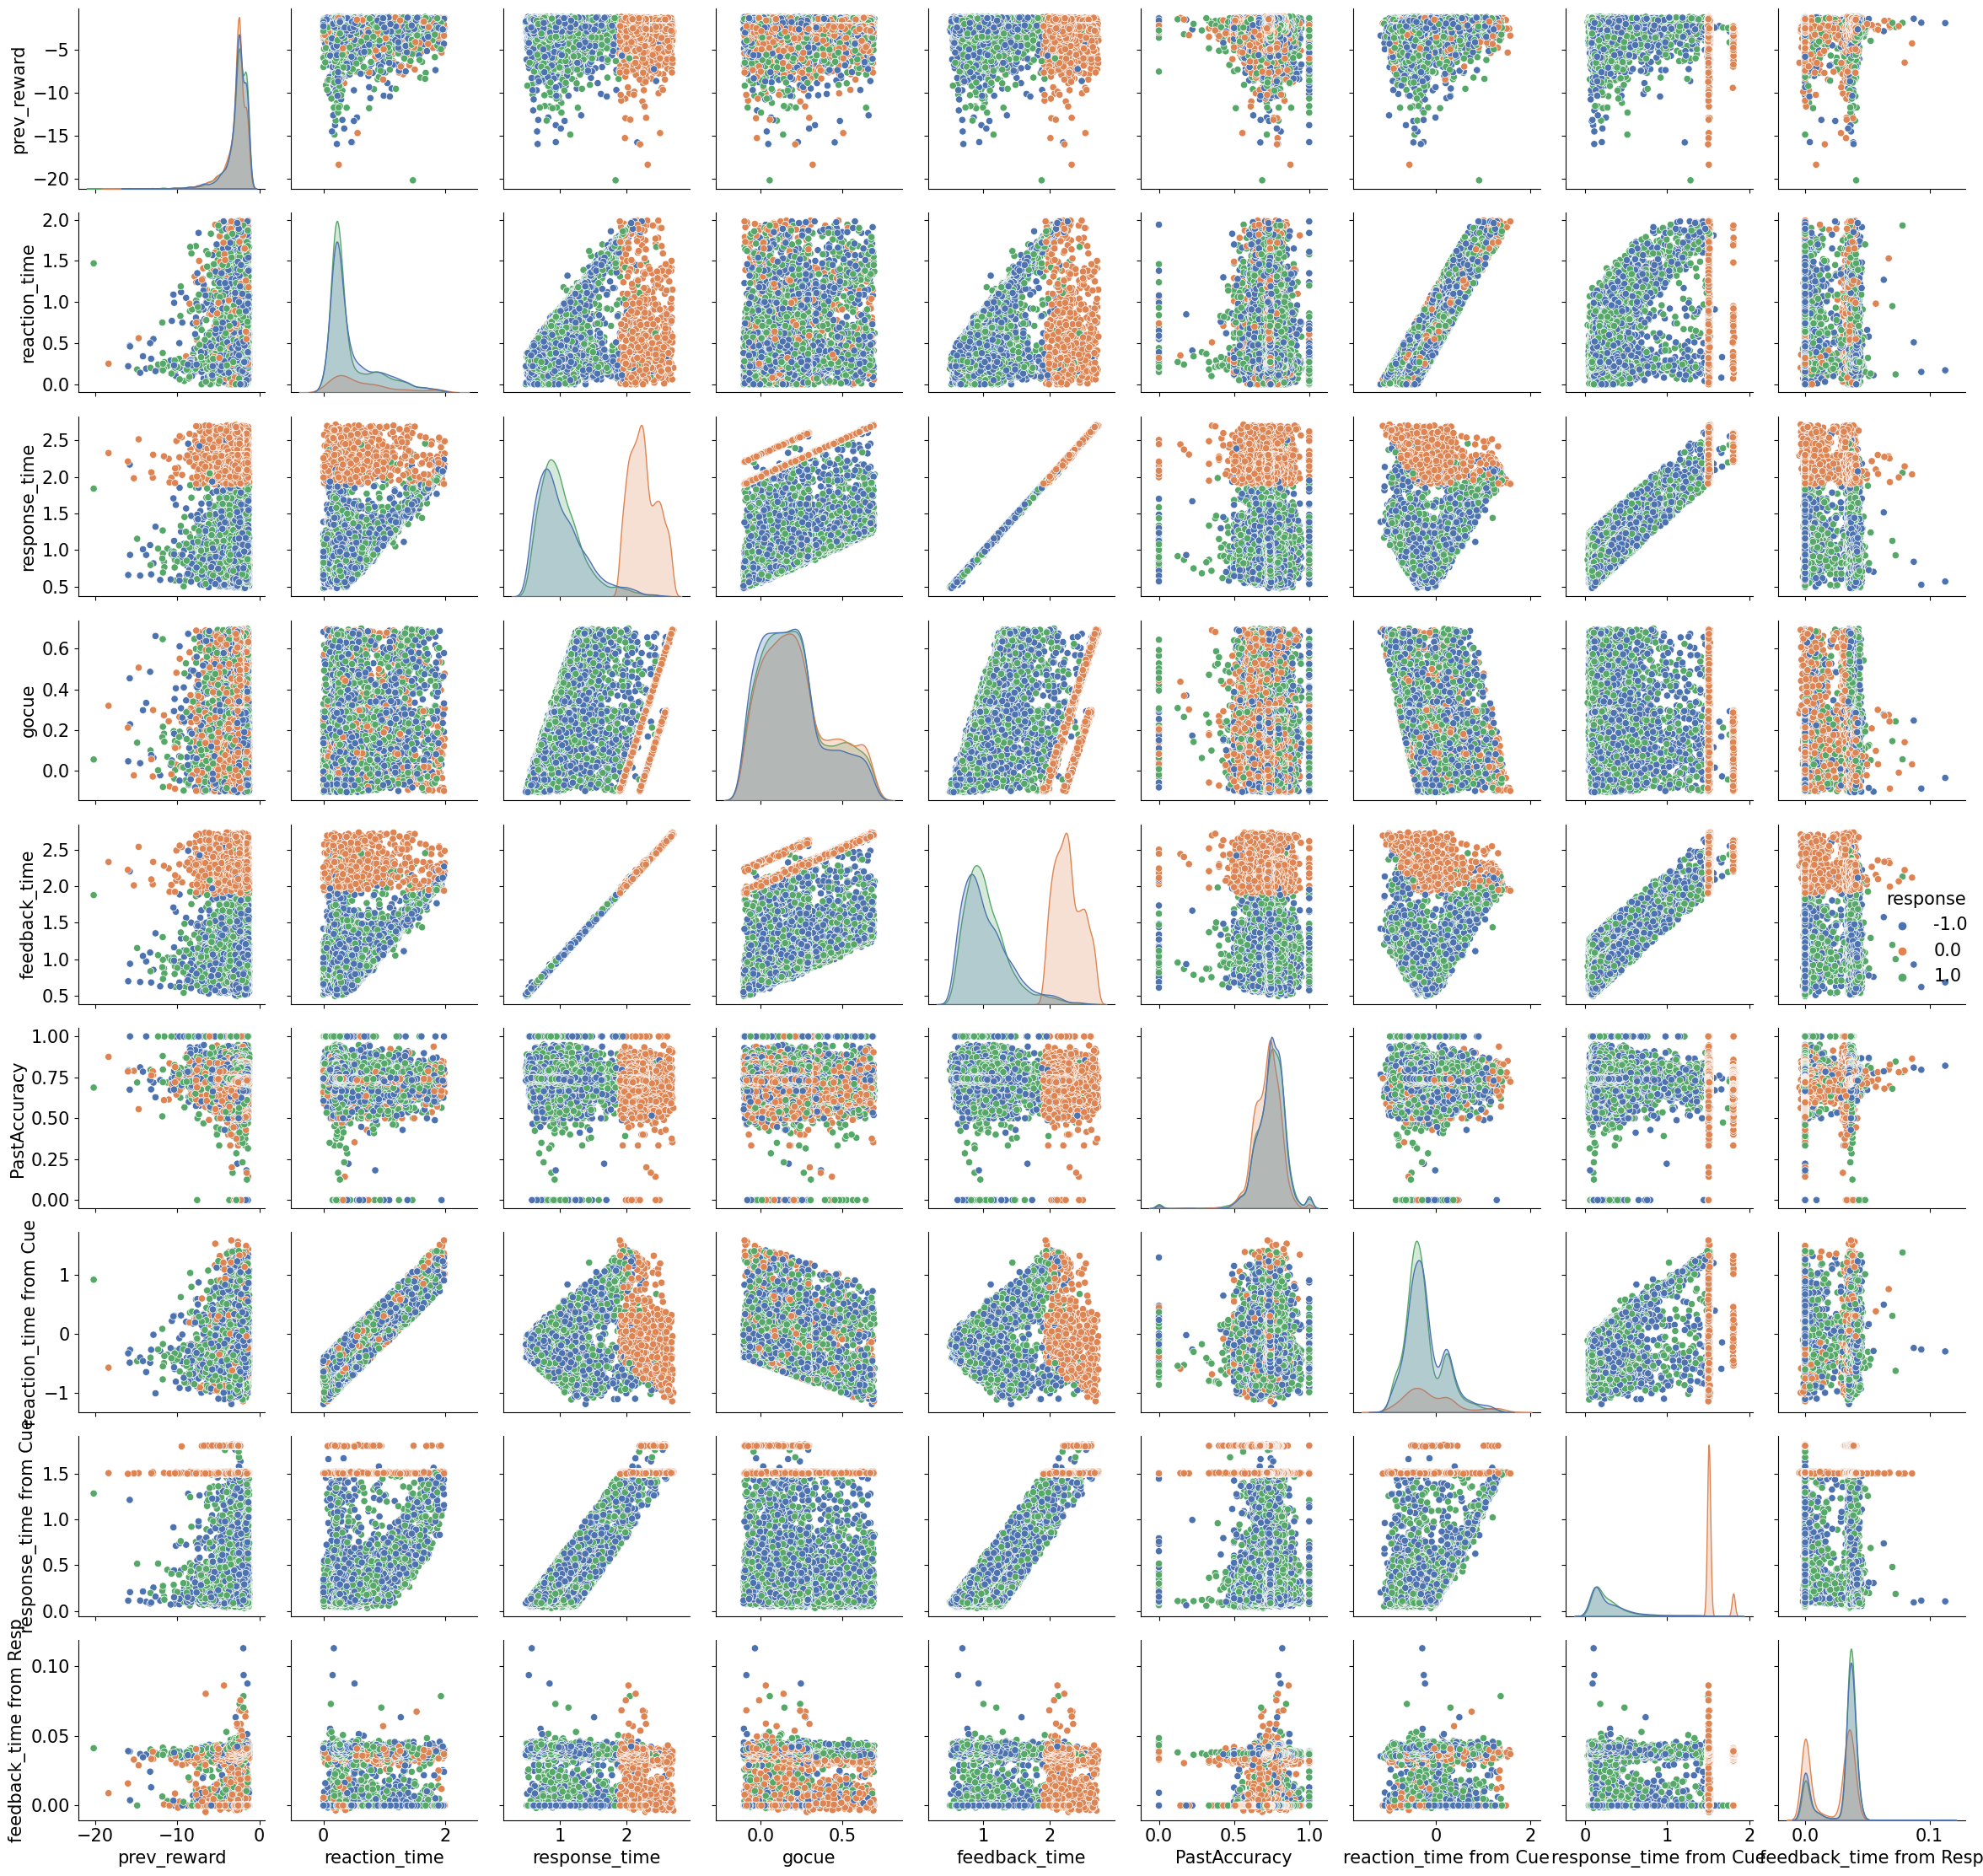

In [ ]:
sns.pairplot(DF, hue='response', diag_kind="kde", palette="deep")

In [ ]:
def calc_past_accuracy(data):
    accuracy = data['feedback_type']
    accuracy[accuracy==-1] = 0
    past_accuracy = np.cumsum(accuracy)/(np.arange(accuracy.shape[0])+1)            #previous rewards(past accuracy)
    past_accuracy = np.insert(past_accuracy,  0, 0. )
    past_accuracy = past_accuracy[:-1]
    return past_accuracy, accuracy


col = ['prev_reward', 'reaction_time', 'response_time', 'gocue', 'response', 'feedback_time']# 'stim_onset'
session = []
dimlistL = {}
for i, ditem in enumerate(alldat):
  for key in col:
    if i==0:
      if key == 'response':
        dimlistL[key] = ditem[key]
      else:
        dimlistL[key] = ditem[key][:,0]
      #print(i, key, dimlistL[key].shape)
    else:
      if key == 'response':
        dimlistL[key] = np.concatenate((dimlistL[key], ditem[key]))
      else:
        dimlistL[key] = np.concatenate((dimlistL[key], ditem[key][:,0]))
      #print(i, key, dimlistL[key].shape)
  #print('\n')
  if i==0:
    CumSum= calc_past_accuracy(ditem)[0]
    feedback_acc = calc_past_accuracy(ditem)[1]
    trialL = np.array(range(len(ditem['response'])))
  else:
    CumSum = np.concatenate((CumSum, calc_past_accuracy(ditem)[0]))
    feedback_acc = np.concatenate((feedback_acc, calc_past_accuracy(ditem)[1]))
    trialL = np.concatenate((trialL, np.array(range(len(ditem['response'])))))
  dimlistL["PastAccuracy"] = CumSum
  dimlistL["FeedBackAccuracy"] = feedback_acc
  dimlistL["Trial"] = trialL


stim_onset = 0.5
#a = np.empty(len(dimlistL[key]))
#a.fill(500)
#dimlistL['stim_onset'] = a

DF = pd.DataFrame(dimlistL)  #, index=session, columns = col)
#DF.columns = col
#DF.index.name = 'Session'
DF['prev_reward'][DF['prev_reward'] ==-10] = DF['prev_reward'].mean()
DF['reaction_time'] = DF['reaction_time']/1000
DF['reaction_time from Cue'] = DF['reaction_time'] - DF['gocue']
DF['response_time from Cue'] = DF['response_time'] - DF['gocue']
DF['gocue'] = DF['gocue'] - stim_onset
DF['feedback_time from Resp'] = DF['feedback_time'] - DF['response_time']

DF.replace([np.inf, -np.inf], np.nan, inplace=True)
DF.dropna(inplace=True)

DF.head(10)



<ipython-input-19-bd3ba07145d8>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['prev_reward'][DF['prev_reward'] ==-10] = DF['prev_reward'].mean()


prev_reward  reaction_time  response_time     gocue  response  \
0    -2.805656           0.17       1.150204  0.527216       1.0   
1    -4.733091           0.23       1.399503  0.374414      -1.0   
2    -3.400174           0.20       0.949291  0.325213       1.0   
3    -4.183592           0.86       2.266802  0.261612       0.0   
4    -3.248887           0.14       0.816776  0.162010       1.0   
5    -2.982886           1.34       1.517107  0.686819       1.0   
6    -3.766578           0.74       1.133210  0.088009      -1.0   
7    -2.383246           0.99       1.349831  0.106410      -1.0   
8    -4.615865           1.18       2.097125  0.091209       0.0   
9    -3.353363           0.20       1.249668  0.571217       1.0   

   feedback_time  PastAccuracy  FeedBackAccuracy  Trial  \
0       1.186819      0.000000               1.0      0   
1       1.437623      1.000000               1.0      1   
2       0.986016      1.000000               1.0      2   
3       2.296436      1.000000               1.0      3   
4       0.827613      1.000000               0.0      4   
5       1.546825      0.800000               0.0      5   
6       1.142018      0.666667               0.0      6   
7       1.356822      0.571429               0.0      7   
8       2.137634      0.500000               1.0      8   
9       1.286820      0.555556               1.0      9   

   reaction_time from Cue  response_time from Cue  feedback_time from Resp  
0               -0.857216                0.122987                 0.036615  
1               -0.644414                0.525089                 0.038120  
2               -0.625213                0.124078                 0.036725  
3                0.098388                1.505190                 0.029635  
4               -0.522010                0.154765                 0.010837  
5                0.153181                0.330288                 0.029718  
6                0.151991                0.545201                 0.008808  
7                0.383590                0.743422                 0.006990  
8                0.588791                1.505916                 0.040509  
9               -0.871217                0.178451                 0.037153

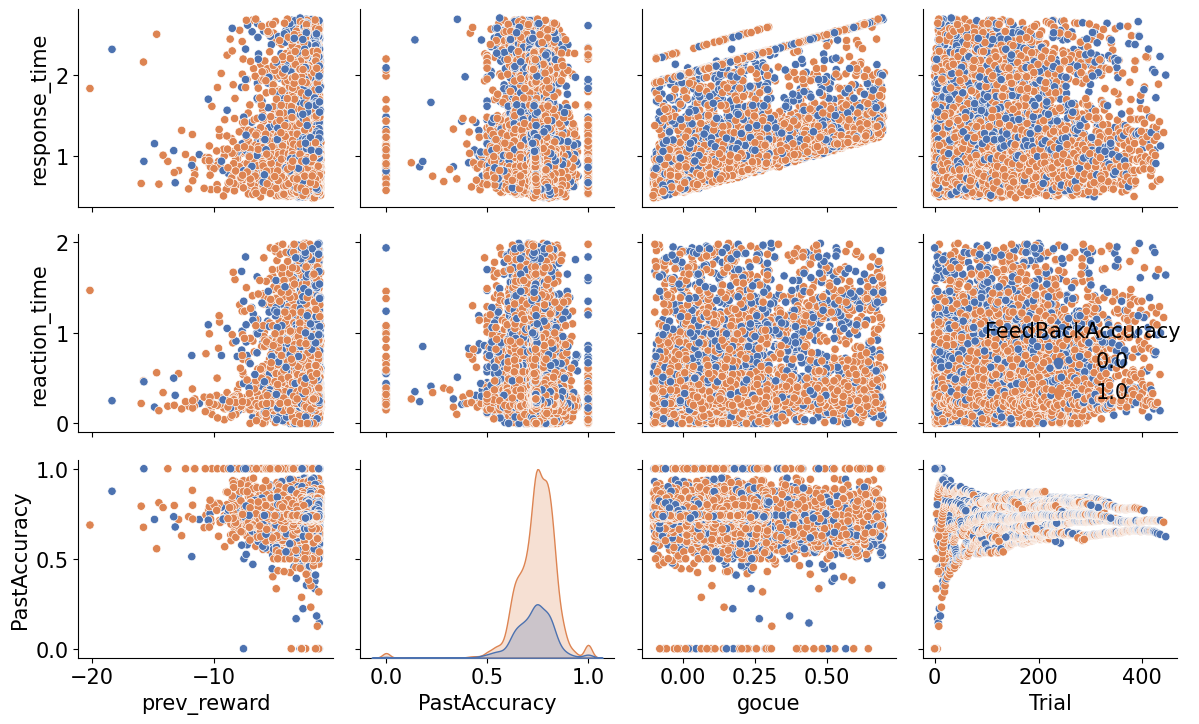

In [ ]:
sns.pairplot(DF, hue="FeedBackAccuracy", diag_kind="kde", palette="deep",
              x_vars=['prev_reward', "PastAccuracy", 'gocue', "Trial"],
              y_vars=['response_time',  'reaction_time', "PastAccuracy"],)

In [ ]:
"""
for i, ditem in enumerate(alldat):
  if ditem['prev_reward'].shape[0] != ditem['response_time'].shape[0]:
    print(i, "fucked")

for i, ditem in enumerate(alldat):
    count_prRev = ditem['prev_reward'].shape[0]
    count_resp = ditem['response_time'].shape[0]
    print(i, count_prRev-count_resp)

for i, ditem in enumerate(alldat):
  print(i,ditem['stim_onset'])

"""

In [ ]:
print('prev_reward', alldat[0]['prev_reward'].shape)
print('reaction_time', alldat[0]['reaction_time'].shape)
print('response_time', alldat[0]['response_time'].shape)
print('gocue', alldat[0]['gocue'].shape)
print('stim_onset', alldat[0]['stim_onset'])
print('feedback_time', alldat[0]['feedback_time'][:5])
print('prev_reward', alldat[0]['prev_reward'].shape)
print('prev_reward', '\n', alldat[0]['prev_reward'][:5])
print('response_time', '\n', alldat[0]['response_time'][:5])
print('reaction_time', '\n', alldat[0]['reaction_time'][:5])

In [ ]:
#alldat[0]['reaction_time'][0:5]
#plt.scatter(alldat[0]['reaction_time'][:,0],  alldat[0]['response_time'])
dif_resp = alldat[0]['reaction_time'][:,0] - alldat[0]['response_time'][:,0]
#plt.scatter(np.array(range(len(dif_resp))), alldat[0]['gocue'][:,0], label='gocue')
#plt.scatter(np.array(range(len(dif_resp))), alldat[0]['response_time'][:,0], label='response_time')
#plt.scatter(np.array(range(len(dif_resp))), alldat[0]['feedback_time'][:,0], label='feedback_time')
plt.scatter(np.array(range(len(dif_resp))), alldat[0]['response_time'][:,0]-alldat[0]['gocue'][:,0], label='response_time - gocue')
plt.scatter(np.array(range(len(dif_resp))), alldat[0]['reaction_time'][:,0]/1000, label= 'reaction_time')
#plt.scatter(np.array(range(len(dif_resp))), alldat[0]['response_time'][:,0]-0.5, label='response_time - stim_onset')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
plt.scatter(alldat[0]['reaction_time'][:,1],  alldat[0]['response'])

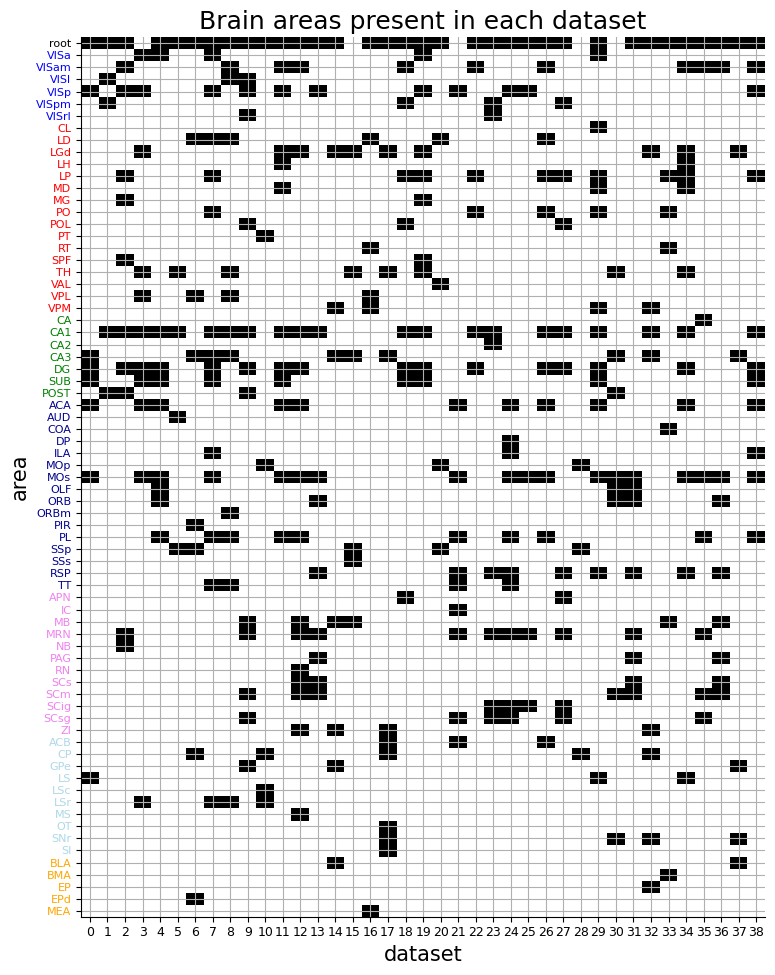

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

In [ ]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

In [ ]:
np.unique(barea)


In [ ]:
# @title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)

  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.show()

In [ ]:
# @title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])
  if np.sum(barea == j) == 0:
    continue
  plt.plot(1/dt * dat['spks'][barea == j][:, response < 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response > 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response == 0].mean(axis=(0, 1)))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel='time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# @title top PC directions from stimulus + response period, with projections of the entire duration

droll = np.reshape(dat['spks'][:, :, 51:130], (NN, -1))  # first 80 bins = 1.6 sec
print(droll.shape)
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
print(droll.shape)
print(np.mean(droll, axis=1)[0:10])
model = PCA(n_components=5).fit(droll.T)
W = model.components_
print(W.shape)
pc_10ms = W @ np.reshape(dat['spks'], (NN, -1))
print(pc_10ms.shape)
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
# @title The top PCs capture most variance across the brain. What do they care about?
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2, len(pc_10ms) + 1, j + 1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2, len(pc_10ms) + 1, len(pc_10ms) + 1 + j + 1)

  plt.plot(pc1[response > 0, :].mean(axis=0))
  plt.plot(pc1[response < 0, :].mean(axis=0))
  plt.plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)
plt.show()

In [ ]:
# @title now sort all trials by response latency and see if the PCs care about that.
isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time', ylabel='trials sorted by latency')
  plt.title('PC %d'%j)
plt.show()

In [ ]:
# @title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response) == np.sign(vis_left - vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10)

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time')
  if j == 0:
    ax.set(ylabel='trials sorted by latency')
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')
plt.show()

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel='binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1, 5, 2)
plt.plot(dat['wheel'][0, response > 0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Left choices')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Right choices')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='No go choices')
plt.show()

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])

  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p == 0)].mean(axis=(0, 1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j == 0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)